In [1]:
import numpy as np
import random
from keras import callbacks
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils
import string
from typing import List, Tuple
import re

random.seed(10)
np.random.seed(10)

In [2]:
import pandas as pd
from pandas import DataFrame


def load_lyrics(csv_path: str) -> DataFrame:
    df = pd.read_csv(csv_path, sep='\n', header=None)
    # res = df.iloc[:, 0].str.rstrip(r'&, ').str.extract(r'([^,]+),([^,]+),(.+)')
    res = df.iloc[:, 0].str.extract(r'([^,]+),([^,]+),(.+)')
    res.columns = ['artist', 'title', 'lyrics']
    return res

def load_songs(path) -> List[str]:
    df = load_lyrics(path)
    for i, song in enumerate(list(df['lyrics'])):

        song += " EOF"
        # remove '(*)'
        modified_song = re.sub(r"\([^()]*\)", "", song)
        modified_song = modified_song.replace("chorus", "").replace('&', '\n').lower()
        regex = re.compile('[%s]' % re.escape(string.punctuation.replace("'","")))
        modified_song = regex.sub('', modified_song)
        df.loc[i, 'lyrics'] = modified_song
    return df

In [3]:
def create_x_y(songs, tokenize, total_words, max_len) -> Tuple[np.ndarray, np.ndarray]:
    input_sequences = []
    midi_meta = []
    for index, row in songs.iterrows():
      line = row['lyrics']
      token_list = tokenize.texts_to_sequences([line])[0]
      midi_metadata = row.drop(['artist', 'title', 'lyrics', 'filename']).values
      for i in range(1, len(token_list)):
          n_gram_sequence = token_list[:i + 1]
          input_sequences.append(n_gram_sequence)
          midi_meta.append(midi_metadata)
    print(input_sequences[:10])
    
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_len, padding='pre'))
    x = input_sequences[:, :-1]
    x_midi = np.array(midi_meta)
    y = input_sequences[:, -1]
    y = utils.to_categorical(y, num_classes=total_words)
    return x, x_midi, y 

def split_df_to_train_val(df, ratio):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_val = df[~mask]
    return df_train, df_val

In [4]:
class LyricsGenerator(object):

    def __init__(self, embedding_dim: int, vocab_size: int, input_size: int, midi_features_size: int, embedding_matrix: np.ndarray):
        input_lyrics = Input(shape=(input_size,))
        embedding_layer = Embedding(
            vocab_size,
            embedding_dim,
            input_length=input_size,
            weights=[embedding_matrix],
            # embeddings_initializer=initializers.Constant(embedding_matrix),
            trainable=False,
        )(input_lyrics)
        lstm = LSTM(units=embedding_dim)(embedding_layer)
        lyrics_model = Dropout(0.2)(lstm)

        input_midi =  Input(shape=(midi_features_size,))
        midi_model = Dense(50, activation='relu')(input_midi)
        midi_model = Dense(10, activation='relu')(midi_model)

        final_model_1 = concatenate([lyrics_model, midi_model])
        final_model = Dense(units=vocab_size, activation='softmax')(final_model_1)
        self.model = Model(inputs=[input_lyrics, input_midi], outputs=final_model)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def fit(self, x, y, hyper_parameters):
        callback = callbacks.EarlyStopping(monitor='loss', patience=3)
        callback2 = callbacks.LearningRateScheduler(self._lr_scheduler)
        # callback3 = callbacks.ModelCheckpoint('lyrics_model.h5', save_best_only=True, monitor='val_loss', mode='min')
        # callback = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
        # history = self.model.fit(x, y, epochs=100, verbose=1)
        history = self.model.fit(x, y, batch_size=hyper_parameters['batch_size'], epochs=hyper_parameters['epochs'],
                                 callbacks=[callback],
                                 # callbacks=[callback, callback2],
                                 verbose=1, validation_split=hyper_parameters['validation_split'],
                                 validation_data=hyper_parameters['val_data'])
        self.model.save('lyrics_model.h5')
        
        return history

    def _lr_scheduler(self, epoch, lr):
        return 0.95 * lr

    def evaluate(self, x, y):
        predictions = self.model.evaluate(x, y)
        return predictions

    # to get a picture of loss progress.
    def plot_metric(self, history: History, metric: str = 'loss') -> None:
        import matplotlib.pyplot as plt
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])
        plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df_songs = load_songs('/content/drive/MyDrive/DL/Assignment_3/Lyrics/lyrics_train_set.csv')

In [7]:
df_songs['lyrics'][1]

"winding your way down on baker street \n lite in your head and dead on your feet \n well another crazy day you drink the night away \n and forget about everything \n this city desert makes you feel so cold \n its got so many people but its got no soul \n and it's taken you so long to find out you were wrong \n when you thought it held everything \n you used to think that it was so easy \n you used to say that it was so easy \n but you're tryin you're tryin now \n another year and then you'd be happy \n just one more year and then you'd be happy \n but you're cryin' you're cryin' now \n way down the street there's a light in his place \n you open the door he's got that look on his face \n and he asks you where you've been you tell him who you've seen \n and you talk about anything \n he's got this dream about buyin' some land \n he's gonna give up the booze and the one night stands \n and then he'll settle down it's a quiet little town \n and forget about everything \n but you know he'

In [8]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DL/Assignment_3/midi_files.zip',"r") as zip_ref:
  zip_ref.extractall("temp_dir")

In [9]:
!pip install mido

     |████████████████████████████████| 51kB 7.9MB/s 


In [8]:
from os import listdir
from mido import MidiFile
from mido.midifiles.meta import KeySignatureError

files_in_dir = [f for f in listdir("temp_dir/midi_files") if re.match('.*\.mid', f)]
df_midi = pd.DataFrame(columns=['filename', 'numerator', 'denominator', 'clocksPerTick', 'demisemiquaverPer24Clocks', 'key', 'mode', 'tempo'])

def parse(file,numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo):
  mid = MidiFile(file, clip=True)
  # for track in mid.tracks:
      # print(track)
  for msg in mid.tracks[0]:
    # print(msg.dict())
    if msg.dict()['type'] == 'key_signature':
      mode = 'minor' if msg.dict()['key'][-1] == 'm' else 'major'
      key = msg.dict()['key'] if mode == 'major' else msg.dict()['key'][:-1]
    if msg.dict()['type'] == 'set_tempo':
      tempo = msg.dict()['tempo']/1000
    if msg.dict()['type'] == 'time_signature':
      numerator = msg.dict()['numerator']
      denominator = msg.dict()['denominator']
      clocksPerTick = msg.dict()['clocks_per_click']
      demisemiquaverPer24Clocks = msg.dict()['notated_32nd_notes_per_beat']
  return numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo

for i, f in enumerate(files_in_dir):
  numerator = denominator = clocksPerTick = demisemiquaverPer24Clocks = -1
  key = mode = 'unknown'
  tempo = -1
  try:
    numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo = parse("temp_dir/midi_files/" + f,numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo)
  except (UnicodeDecodeError, KeySignatureError, EOFError) as e:
    continue

  print(f'{numerator},{denominator},{clocksPerTick},{demisemiquaverPer24Clocks},{key},{mode},{tempo}')
  df_tmp = pd.DataFrame([[f.lower(),numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo ]], columns=['filename', 'numerator', 'denominator', 'clocksPerTick', 'demisemiquaverPer24Clocks', 'key', 'mode', 'tempo'])
  df_midi= pd.concat([df_midi, df_tmp])
# print(f'{numerator},{denominator},{clocksPerTick},{demisemiquaverPer24Clocks},{key},{mode},{tempo}')
# print(mid)

4,4,24,8,C,major,461.538
4,4,24,8,unknown,unknown,625.0
4,4,24,8,C,major,705.882
4,4,24,8,Ab,major,375.0
4,4,24,8,C,major,545.454
4,4,96,8,unknown,unknown,626.959
4,4,24,8,F,major,750.0
4,4,24,8,unknown,unknown,434.782
4,4,24,8,C,major,545.454
4,4,24,8,C,major,1052.632
4,4,24,8,D,minor,480.0
4,4,24,8,C,major,472.441
4,4,24,8,C,major,638.298
4,4,24,8,C,major,487.805
4,4,24,8,C,major,800.0
4,4,24,8,E,major,1250.0
4,4,24,8,C,major,625.0
4,4,24,8,C,major,500.0
4,4,24,8,C,major,500.0
4,4,24,8,unknown,unknown,588.235
4,4,24,8,C,major,722.892
4,4,24,8,C,major,779.221
4,4,24,8,C,major,600.0
4,4,24,8,unknown,unknown,847.488
4,4,24,8,C,major,666.667
4,4,24,8,C,major,443.787
4,4,24,8,C,major,731.707
4,4,24,8,C,major,500.0
4,4,24,8,C,major,545.455
4,4,24,8,C,major,500.0
4,4,24,8,C,major,500.0
4,4,24,8,G,major,525.855
4,4,24,8,C,major,545.455
4,4,24,8,C,major,631.579
4,4,24,8,G,major,550.459
4,4,24,8,D,major,535.714
4,4,24,8,C,major,606.061
4,4,24,8,C,major,571.428
4,4,24,8,unknown,unknown,461.538


In [11]:
df_midi

,filename,numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo
0,2_unlimited_-_tribal_dance.mid,4,4,24,8,C,major,461.538
0,bloodhound_gang_-_fire_water_burn.mid,4,4,24,8,unknown,unknown,625.000
0,98_degrees_-_i_do_cherish_you.mid,4,4,24,8,C,major,705.882
0,adele_-_hello.mid,4,4,24,8,Ab,major,375.000
0,christmas_carols_-_do_you_hear_what_i_hear.mid,4,4,24,8,C,major,545.454
...,...,...,...,...,...,...,...,...
0,gino_vannelli_-_i_just_wanna_stop.mid,4,4,24,8,C,major,1071.429
0,dixie_chicks_-_i_can_love_you_better.mid,4,4,24,8,E,major,500.000
0,the_eagles_-_the_last_resort.mid,4,4,24,8,C,major,983.607
0,dionne_warwick_-_i_say_a_little_prayer.mid,4,4,96,8,unknown,unknown,434.782


In [9]:
df_songs['filename'] = df_songs['artist'].str.replace(' ', "_") + "_-_" + df_songs['title'].str.replace(' ', "_") + ".mid"
df_merged = pd.merge(df_songs, df_midi, on="filename")

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

scalers = []
columns = ['numerator', 'denominator','clocksPerTick', 'demisemiquaverPer24Clocks', 'tempo']
for col in columns:
  scaler = MinMaxScaler()
  scaled_features = scaler.fit_transform(df_merged[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_merged.index, columns=[col])
  df_merged[col] = tmp_df[col]
  scalers.append(scaler)


onehot_encoders = []
columns = ['key', 'mode']
for col in columns:
  onehot_encoder = OneHotEncoder(sparse=False)
  scaled_features = onehot_encoder.fit_transform(df_merged[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_merged.index)
  tmp_df.columns = onehot_encoder.get_feature_names([col])
  df_merged.drop([col] ,axis=1, inplace=True)
  df_merged = pd.concat([df_merged, tmp_df ], axis=1)
  onehot_encoders.append(onehot_encoder)

In [14]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DL/Assignment_3/glove.6B.zip',"r") as zip_ref:
  zip_ref.extractall("glove")

In [11]:
tokenize = Tokenizer(filters='')
tokenize.fit_on_texts(df_merged['lyrics'])
total_words = len(tokenize.word_index) + 1
embedding_dim = 300

In [12]:
import pickle
f = open("tokenizer_pickle", "wb")
pickle.dump(tokenize, f)
f.close()

In [13]:
#taken from https://gist.github.com/shubham0204/531f75c37c49362c9b61a11865496177
import numpy as np
import pickle
import os

# You need to download the GloVe embeddings ( in txt files ) from here -> http://nlp.stanford.edu/data/glove.6B.zip

# The vocabulary size. It is the value of `len( tokenizer.word_index )+1`
vocab_size = total_words #int(input('Enter Vocabulary Size : '))

# The file to the GloVe file. For instance, "glove.6B/glove.6B.50d" where "50" represents the output dimension of the embedding.
glove_path = "/content/glove/glove.6B.300d.txt" #input('Enter path to GloVe text file : ')

# The filepath of the tf.keras.preprocessing.text.Tokenizer object in pickled form. 
# This object was earlier used to tokenize the question and answer pairs. 
tokenizer_path = "/content/tokenizer_pickle" #input('Enter pickled Tokenizer path : ')

# The output directory where the files will be stored.
output_dir = "/content" #input( 'Enter path of output directory : ')

# The output dimensions for the embedding. If the `glove_path` refers to `glove.6B.50d` then this argument should be equal to 50.
output_dim = embedding_dim #int(input('Enter output dimension for Embedding : '))

# The filename for the saved numpy array. For example, "embedding_matrix.npy"
embedding_filename = "embedding_matrix_6b.npy" #input('Enter file name : ' )

# load the whole embedding into memory
embeddings_index = dict()
f = open( glove_path , encoding='utf8' )
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

tokenizer = pickle.load( open( tokenizer_path , 'rb' ) )

embedding_matrix = np.zeros((vocab_size, output_dim))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

np.save( os.path.join( output_dir , '{}'.format( embedding_filename )) , embedding_matrix )

Loaded 400001 word vectors.


In [18]:
# gloveFile = "/content/glove/glove.6B.300d.txt"
# import numpy as np
# def loadGloveModel(gloveFile):
#     print ("Loading Glove Model")
#     with open(gloveFile, encoding="utf8" ) as f:
#         content = f.readlines()
#     model = {}
#     for line in content:
#         splitLine = line.split()
#         word = splitLine[0]
#         embedding = np.array([float(val) for val in splitLine[1:]])
#         model[word] = embedding
#     print ("Done.",len(model)," words loaded!")
#     return model

# model = loadGloveModel(gloveFile)



In [19]:
# words1=[',']
# vector_2 = np.mean([model[word] for word in words1],axis=0) ## Got error message

In [20]:
# vector_2

In [14]:
embedding_matrixs =  np.load("/content/embedding_matrix_6b.npy")
# embedding_matrixs =  np.load("/content/drive/MyDrive/DL/Assignment_3/Lyrics/embedding_matrix_6b_no_eof.npy")

embedding_matrixs.shape

(7627, 300)

In [15]:
def remove_words(words: List[str], songs):
    resulting_songs = []
    for song in songs:
        result = song
        for word in words:
            result = result.replace(word, '')
        resulting_songs.append(result)
    return resulting_songs

In [16]:
import json
non_words_json = json.load(open('/content/drive/MyDrive/DL/Assignment_3/Lyrics/non_words.json', "r"))
non_words_list = non_words_json["non existing words"]
df_merged['lyrics'] = remove_words(non_words_list, df_merged['lyrics'])

In [17]:
# max_sequence_len = df_merged['lyrics'].str.split().apply(len).max()-1
max_sequence_len = 8
df_train, df_val = split_df_to_train_val(df_merged, ratio=0.9)
x_train, x_train_midi, y_train = create_x_y(df_train, tokenize, total_words, max_sequence_len)
x_val, x_val_midi, y_val = create_x_y(df_val, tokenize, total_words, max_sequence_len)
x_train_midi = np.asarray(x_train_midi).astype('float32')
x_val_midi = np.asarray(x_val_midi).astype('float32')

[[221, 2435], [221, 2435, 2436], [221, 2435, 2436, 1], [221, 2435, 2436, 1, 319], [221, 2435, 2436, 1, 319, 4], [221, 2435, 2436, 1, 319, 4, 46], [221, 2435, 2436, 1, 319, 4, 46, 214], [221, 2435, 2436, 1, 319, 4, 46, 214, 2], [221, 2435, 2436, 1, 319, 4, 46, 214, 2, 68], [221, 2435, 2436, 1, 319, 4, 46, 214, 2, 68, 19]]
[[27, 71], [27, 71, 50], [27, 71, 50, 5], [27, 71, 50, 5, 67], [27, 71, 50, 5, 67, 7], [27, 71, 50, 5, 67, 7, 277], [27, 71, 50, 5, 67, 7, 277, 1], [27, 71, 50, 5, 67, 7, 277, 1, 30], [27, 71, 50, 5, 67, 7, 277, 1, 30, 680], [27, 71, 50, 5, 67, 7, 277, 1, 30, 680, 76]]


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 7, 300)       2288100     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 300)          721200      embedding[0][0]                  
______________________________________________________________________________________________

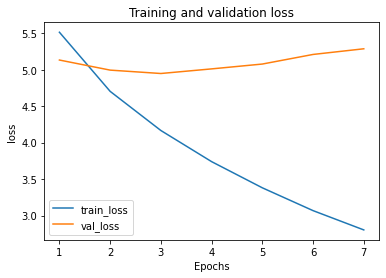

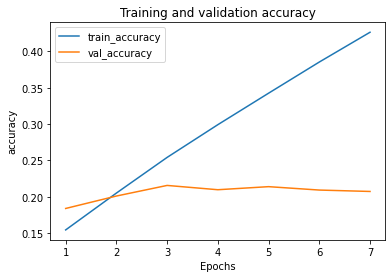

In [18]:
# Train model
parameters = {
    'batch_size' : 128 ,
    'validation_split' : None ,
    'epochs' : 7 ,
    'val_data' :  ([x_val, x_val_midi], y_val)
}
lyrics_generator = LyricsGenerator(embedding_dim, total_words, x_train.shape[1], x_train_midi.shape[1], embedding_matrixs)
h = lyrics_generator.fit([x_train, x_train_midi], y_train, parameters)
lyrics_generator.plot_metric(h)
lyrics_generator.plot_metric(h, metric="accuracy")

In [19]:
df_songs_test = load_songs('/content/drive/MyDrive/DL/Assignment_3/Lyrics/lyrics_test_set.csv')
df_songs_test['filename'] = df_songs_test['artist'].str.replace(' ', "_") + "_-" + df_songs_test['title'].str.replace(' ', "_") + ".mid"
df_test = pd.merge(df_songs_test, df_midi, on="filename")

columns = ['numerator', 'denominator','clocksPerTick', 'demisemiquaverPer24Clocks', 'tempo']
for i, col in enumerate(columns):
  scaled_features = scalers[i].transform(df_test[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_test.index, columns=[col])
  df_test[col] = tmp_df[col]


columns = ['key', 'mode']
for i, col in enumerate(columns):
  scaled_features = onehot_encoders[i].transform(df_test[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_test.index)
  tmp_df.columns = onehot_encoders[i].get_feature_names([col])
  df_test.drop([col] ,axis=1, inplace=True)
  df_test = pd.concat([df_test, tmp_df ], axis=1)

x_test, x_test_midi, y_test = create_x_y(df_test, tokenize, total_words, max_sequence_len)
x_test_midi = np.asarray(x_test_midi).astype('float32')

[[330, 14], [330, 14, 111], [330, 14, 111, 110], [330, 14, 111, 110, 8], [330, 14, 111, 110, 8, 14], [330, 14, 111, 110, 8, 14, 279], [330, 14, 111, 110, 8, 14, 279, 674], [330, 14, 111, 110, 8, 14, 279, 674, 1], [330, 14, 111, 110, 8, 14, 279, 674, 1, 29], [330, 14, 111, 110, 8, 14, 279, 674, 1, 29, 2]]


In [20]:
prediction = lyrics_generator.evaluate([x_test, x_test_midi], y_test)
print(prediction)

39/39 [==============================] - 0s 5ms/step - loss: 4.8542 - accuracy: 0.2430
[4.854175090789795, 0.2429831624031067]


In [21]:
def generate_text(x, eof, model, max_sequence_len, vocab_size):
    seed_text, midi_metadata = x
    next_word = ""
    word_indices = np.arange(vocab_size)# + 1
    word_count = 0
    while next_word != eof:
      token_list = tokenize.texts_to_sequences([seed_text])[0]
      token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
      predicted_proba = model.model.predict_on_batch([token_list, midi_metadata])
      # print(token_list)
      # print(predicted_proba.reshape((predicted_proba.shape[1])).shape)
      # sample the word index acording to predicted proba 
      chosen_index = np.random.choice(word_indices ,1 ,replace=False, p=predicted_proba.reshape((predicted_proba.shape[1])))
      # print(sum(predicted_proba.reshape((predicted_proba.shape[1]))))
      # do not repeat a word if it was in last 5
      while chosen_index in token_list[:5]:
        chosen_index = np.random.choice(word_indices ,1 ,replace=False, p=predicted_proba.reshape((predicted_proba.shape[1])))
      word_count += 1
      next_word = tokenize.sequences_to_texts([chosen_index])[0]
      seed_text += " " + next_word
    print(f'total number of words {word_count}')
    return seed_text

In [27]:
print(generate_text(['forgive', x_test_midi[0].reshape(1,x_test_midi[0].size)], "eof" , lyrics_generator , max_sequence_len, total_words).replace("&","\n"))

total number of words 863
forgive me the world to make you 
 gimme that night fever bring someone in tennessee 
 he tells me how to do is that way 
 oh as his temper son says respect 
 you raw why just don't i heard it maybe to me 
 couldn't got somewhere in a winter day 
 than the night i die and you 
 breaky about how much it did seem 
 i'm switch to blame up on the ground 
 right into down till and i've wrong 
 you're alone here out of break other's when we shall be on 
 and it love will have ya to the puzzle girl 
 you need me that way best day and can't so melodic i moves on 
 you can put me work the can't 
 save it blow face down that door 
 i heard for the blue say hold me a shock 
 victim more into myself just by the blind soul 
 i'm riding and voices you like i got to start up in the second 
 and there's tellin' you through the right control your speak 
 so i let the world back to show 
 and his time i'm leave me at least who wait 
 one day that i could find you were so too lo